# Getting started

In [58]:
### Load packages
library(data.table)
library(readxl)
library(stringr)
library(dplyr)
library(forecast)
library(ggplot2)
library(tseries)
library(stats)
library(psych)
library(fUnitRoots)
library(lmtest)
library(pastecs)
library(FitAR)
library(aTSA)
library(itsmr)
library(pracma)
library(arfima)
library(dse)
library(smooth)
library(fGarch)

In [59]:
list.files(pattern = ".csv")

[1] "^BSESN.csv"    "^GSPC.csv"     "^HSI.csv"      "^JKSE.csv"    
 [5] "^MERV.csv"     "^N225.csv"     "^NSEI.csv"     "^NZ50.csv"    
 [9] "^STOXX50E.csv" "000001.SS.csv"

# Stock 1
## About Hong Kong Hang Seng Index
The HSI is a highly active market with a 1,748,940,800
average volume over the past month. By the Efficient
Market Hypothesis (EMH), it is believed that the time
series process of HSI would be white noise and we could
not forecast the future returns based on historical data. 


## HSI - Data Exploration

In [60]:
# Load data

df = read.csv('^HSI.csv')
df %>% setDT
df = df[,.(date = as.Date(Date),
                 Price = Adj.Close%>% as.character %>% as.numeric)]
df = df[date>='2019-05-04' & date <= '2020-05-08',]
df = na.omit(df)
setkey(df, date)
df %>% tail

Warning message in function_list[[k]](value):
"NAs introduced by coercion"


date,Price
<date>,<dbl>
2020-04-29,24643.59
2020-05-04,23613.80
2020-05-05,23868.66
2020-05-06,24137.48
2020-05-07,23980.63
2020-05-08,24230.17


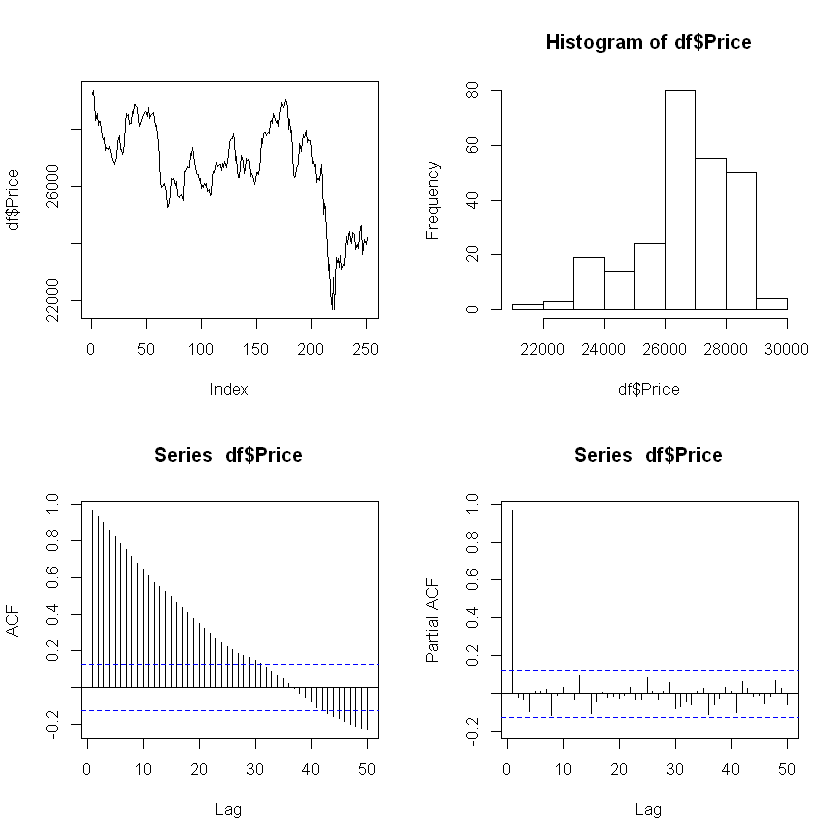

In [64]:
par(mfrow=c(2,2))

# Graph of the index

plot(df$Price, type = "l")

# Histogram

hist(df$Price)

# ACFs and PACFs 

Acf(df$Price, lag.max = 50)

Pacf(df$Price, lag.max = 50)

In [65]:
# Augmented Dickey-Fuller Test

aTSA::adf.test(df$Price, nlag = NULL, output = TRUE)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -1.014   0.316
[2,]   1 -1.071   0.296
[3,]   2 -0.946   0.341
[4,]   3 -0.698   0.429
[5,]   4 -0.801   0.393
Type 2: with drift no trend 
     lag   ADF p.value
[1,]   0 -1.75   0.424
[2,]   1 -1.76   0.421
[3,]   2 -1.78   0.413
[4,]   3 -1.91   0.364
[5,]   4 -1.80   0.406
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -2.11   0.528
[2,]   1 -2.08   0.542
[3,]   2 -2.18   0.501
[4,]   3 -2.48   0.375
[5,]   4 -2.30   0.447
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


From the graph and ACF plot, we can see the persistence of the price is very high. It brings the question whether it is nonstationary. Checking with Augmented Dickey-Fuller test , the p-values are all greater than 0.05, meaning unit root exists. So, we need to use log differences to make it mean stationary:
$R_t = log(P_t) - log(P_{t-1})$

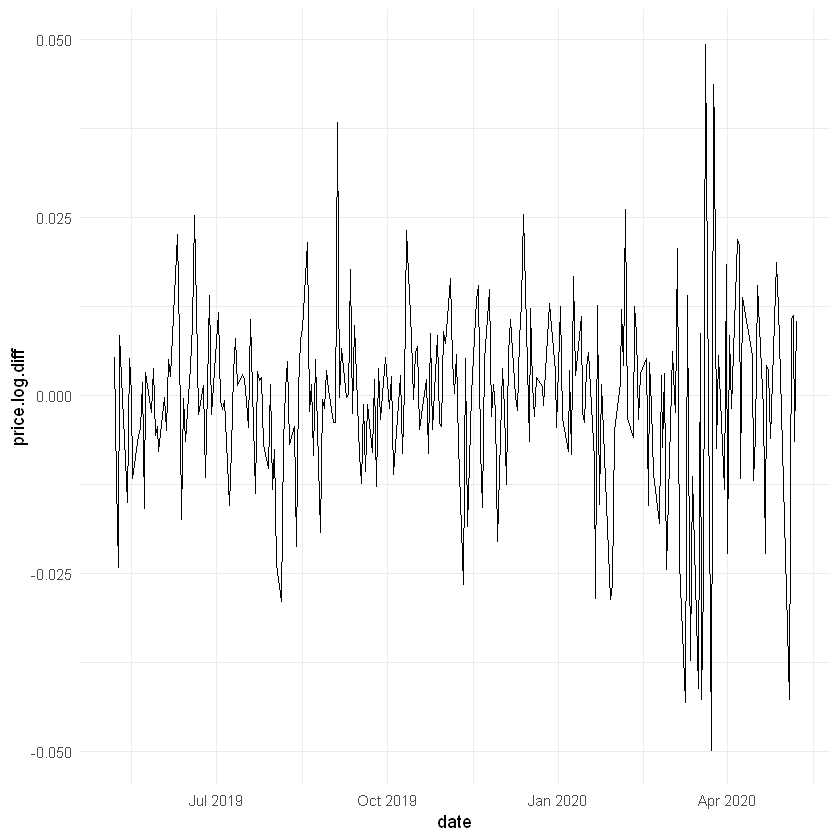

In [66]:
df[, price.lag.1:= shift(Price, type = 'lag', n=1) ]
df[, price.log.diff := log(Price) - log(price.lag.1)]
df = na.omit(df)
ggplot(df, aes(x=date)) + geom_line(aes(y=price.log.diff,group=1))+ theme_minimal() 

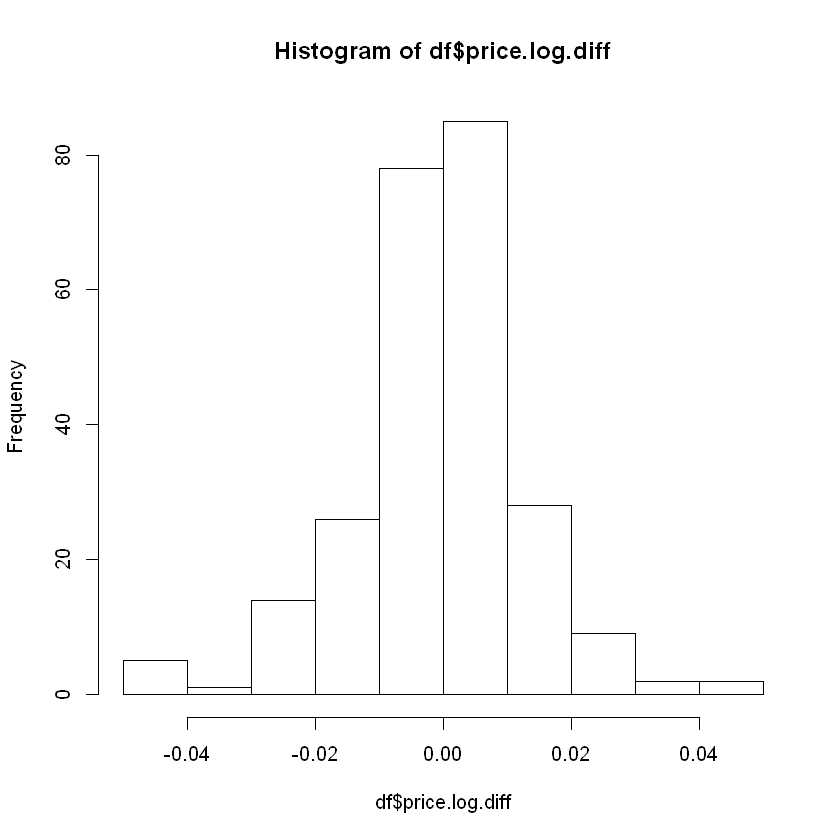

In [69]:
# Histogram
hist(df$price.log.diff)

In [67]:
# Descriptive statistics 

stat.desc(df$price.log.diff)

nbr.val      nbr.null        nbr.na           min           max 
 2.500000e+02  0.000000e+00  0.000000e+00 -4.984895e-02  4.924994e-02 
        range           sum        median          mean       SE.mean 
 9.909889e-02 -1.869064e-01  9.913463e-05 -7.476257e-04  8.598831e-04 
 CI.mean.0.95           var       std.dev      coef.var 
 1.693571e-03  1.848497e-04  1.359595e-02 -1.818550e+01

In [68]:
# Mode

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}
getmode(df$price.log.diff)

[1] 0.005231079

In [27]:
# Kurtosis

kurtosis(df$price.log.diff)

[1] 2.247064
attr(,"method")
[1] "excess"

In [28]:
# Skewness

skewness(df$price.log.diff)

[1] -0.2821722
attr(,"method")
[1] "moment"

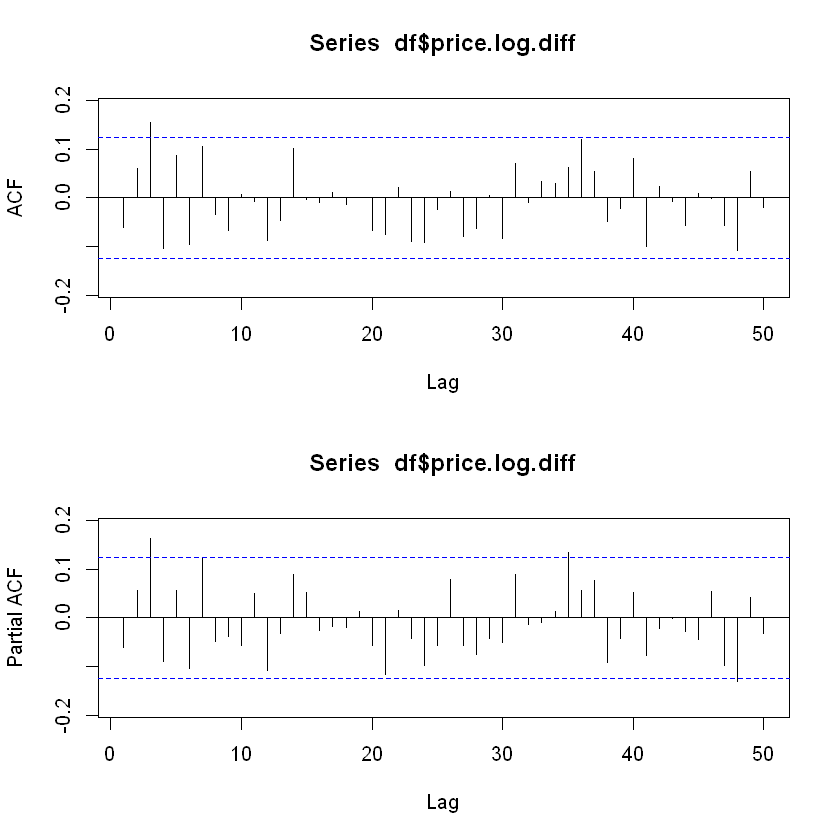

In [29]:
# ACFs and PACFs 
par(mfrow=c(2,1))

Acf(df$price.log.diff, lag.max = 50)

Pacf(df$price.log.diff, lag.max = 50)

In [30]:
# Augmented Dickey-Fuller Test

aTSA::adf.test(df$price.log.diff, nlag = NULL, output = TRUE)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -16.68    0.01
[2,]   1 -10.73    0.01
[3,]   2  -7.54    0.01
[4,]   3  -7.34    0.01
[5,]   4  -6.26    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -16.70    0.01
[2,]   1 -10.76    0.01
[3,]   2  -7.55    0.01
[4,]   3  -7.36    0.01
[5,]   4  -6.28    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -16.67    0.01
[2,]   1 -10.74    0.01
[3,]   2  -7.54    0.01
[4,]   3  -7.35    0.01
[5,]   4  -6.28    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


In [31]:
#  Ljung-Box Test
Box.test(df$price.log.diff, lag = 50, type = "Ljung-Box")


	Box-Ljung test

data:  df$price.log.diff
X-squared = 58.388, df = 50, p-value = 0.1944


After transforming, the return seems mean stationary, however, is obviously variance non-stationary from the plot. From the Augmented Dickey-Fuller test , the coefficients are all negative in the three types of test, and the p-value is smaller than 0.01, indicating the data do not have unit root and is covariance stationary. 
From the ACF and PACF graph, the first two lags are not statistically significant. From the Ljung-Box test , the p-value is greater than 0.05, meaning we fail to reject the null hypothesis that the autocorrelations are all zero. Therefore, we can conclude it is indeed a white noise process.

## HSI - Model Selection

In [70]:
# prepare ts data

df.ts = df[ date < '2020-05-04', list(date, price.log.diff)] 
tsdata = ts(df.ts$price.log.diff, start = df$date[1], frequency = 365)
print(paste("Number of observations:",length(tsdata)))

[1] "Number of observations: 245"


In [71]:
#  fitting different ARMA models and compare with AIC

auto.arima(tsdata, trace=TRUE)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2)             with non-zero mean : -1415.134
 ARIMA(0,0,0)             with non-zero mean : -1414.662
 ARIMA(1,0,0)             with non-zero mean : -1412.432
 ARIMA(0,0,1)             with non-zero mean : -1413.14
 ARIMA(0,0,0)             with zero mean     : -1416.037
 ARIMA(1,0,1)             with non-zero mean : -1410.637

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,0,0)             with zero mean     : -1416.037

 Best model: ARIMA(0,0,0)             with zero mean     



Series: tsdata 
ARIMA(0,0,0) with zero mean 

sigma^2 estimated as 0.0001794:  log likelihood=709.03
AIC=-1416.05   AICc=-1416.04   BIC=-1412.55

Using AIC as model selection criterion, the best model estimated is ARMA(2,0), though the AIC for ARMA(0,0) is similar.

#### ARMA(0,0)

In [72]:
fitARIMA <- arima(tsdata, order=c(0,0,0),method="ML", include.mean = TRUE)
coeftest(fitARIMA)


z test of coefficients:

             Estimate  Std. Error z value Pr(>|z|)
intercept -0.00069383  0.00085697 -0.8096   0.4182


In [73]:
coefficients(fitARIMA)

intercept 
-0.0006938292

In [74]:
confint(fitARIMA)

,2.5 %,97.5 %
intercept,-0.002373455,0.0009857971


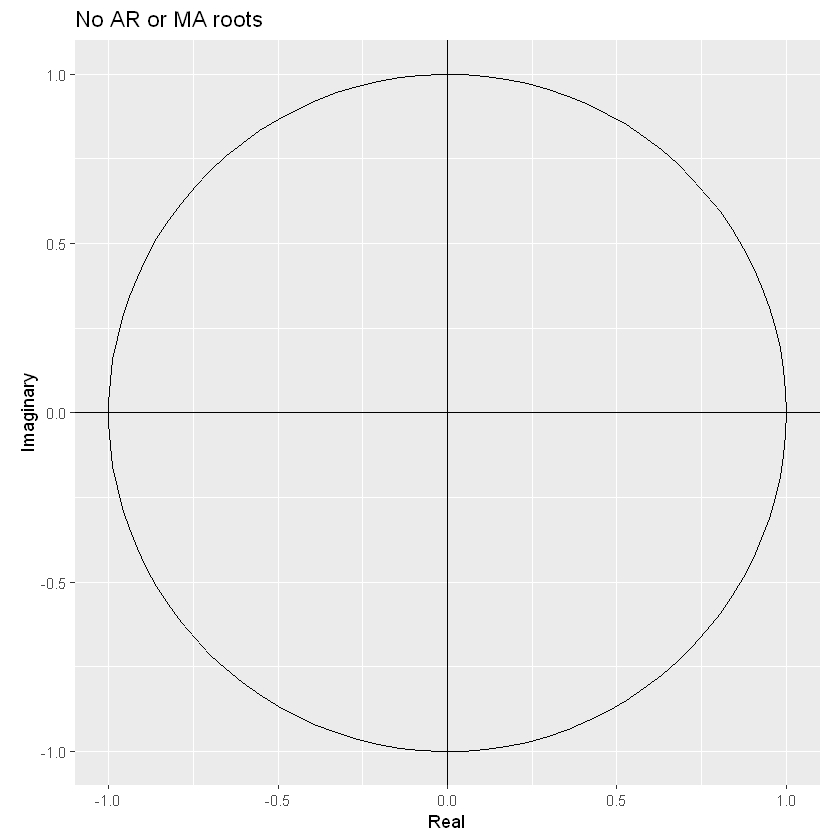

In [75]:
# Inverse characteristic roots
autoplot(fitARIMA)

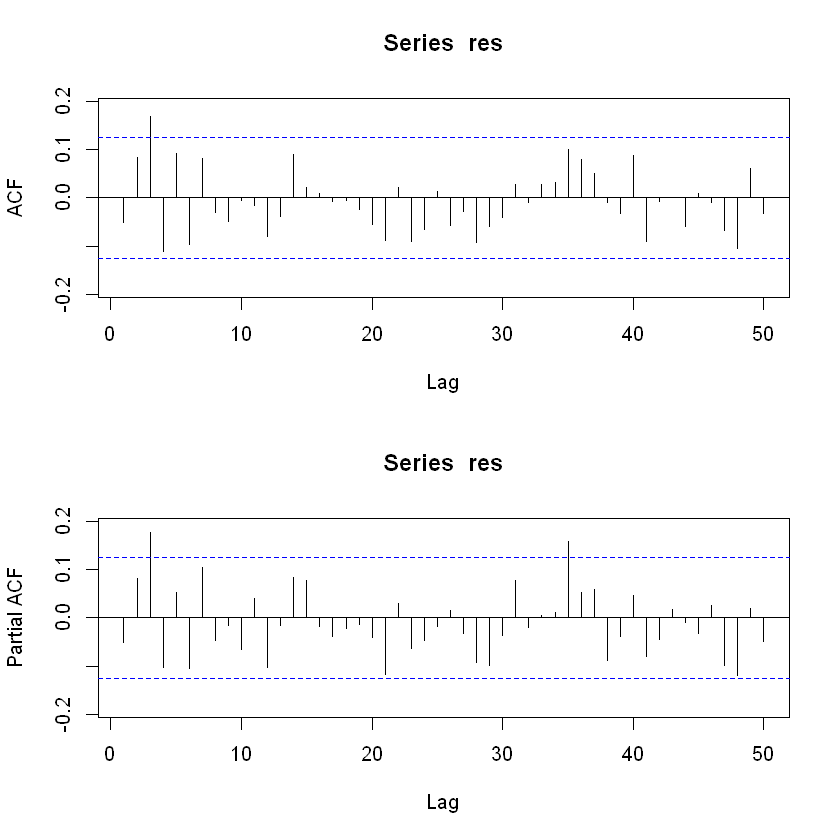

In [76]:
res = residuals(fitARIMA)
# ACFs and PACFs  of residuals 
par(mfrow=c(2,1))

Acf(res, lag.max = 50)

Pacf(res, lag.max = 50)

In [77]:
#  Ljung-Box Test
Box.test(res, lag = 50, type = "Ljung-Box")


	Box-Ljung test

data:  res
X-squared = 54.404, df = 50, p-value = 0.3105


Since p-value > 0.05, it means the residuals are independent at 95% level, thus ARMA(0,0) is a good fit


	Ljung-Box test

data:  Residuals from ARIMA(0,0,0) with non-zero mean
Q* = 54.078, df = 48, p-value = 0.2536

Model df: 1.   Total lags used: 49



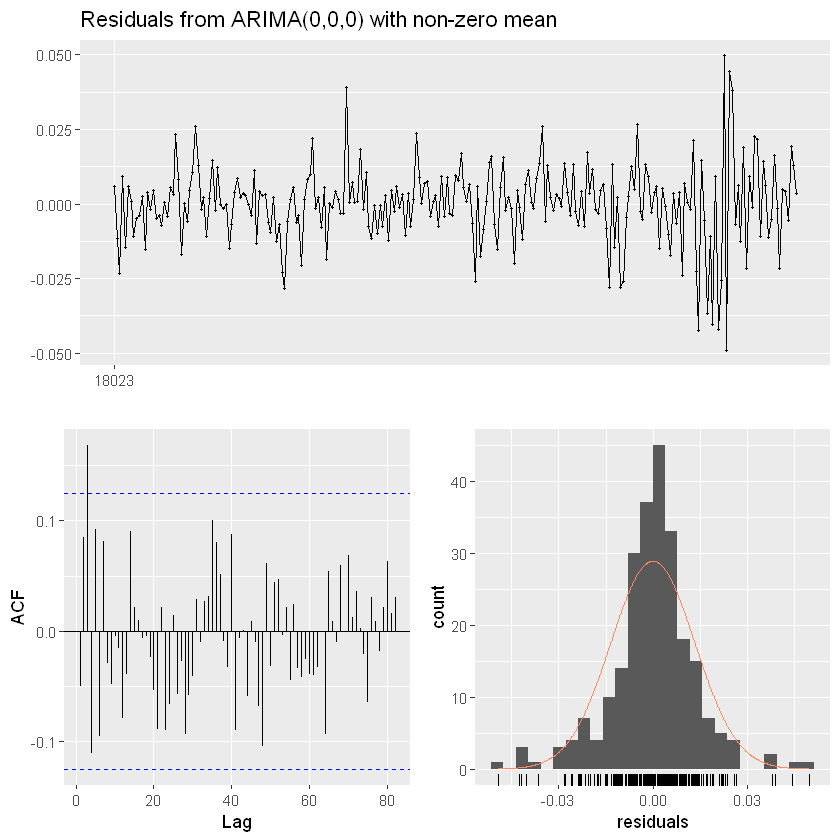

In [78]:
checkresiduals(fitARIMA)

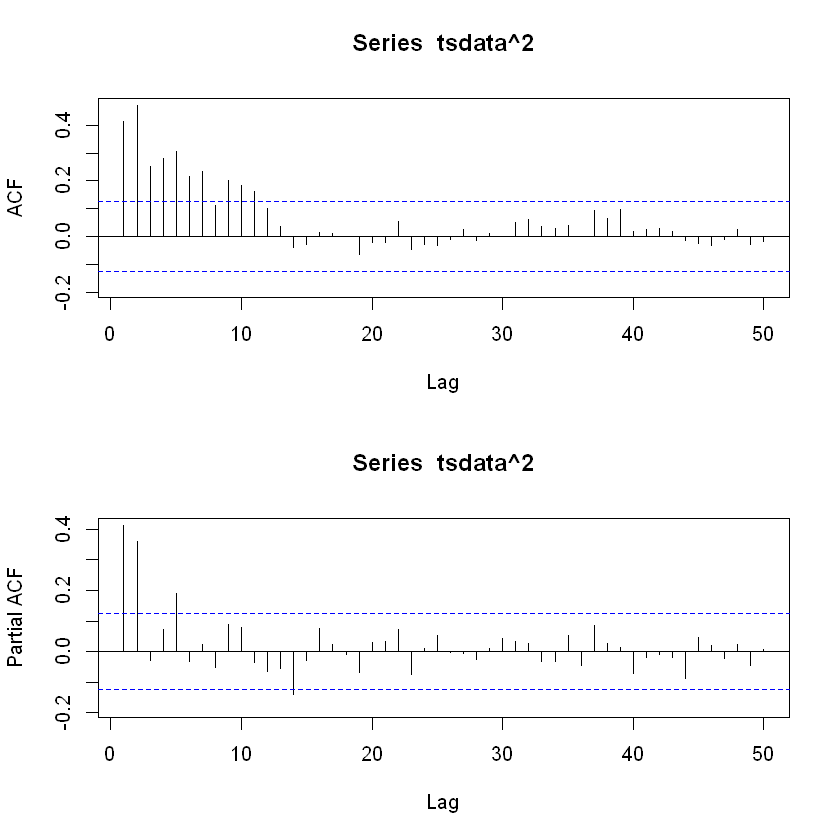

In [79]:
# res = residuals(fitARIMA)
# ACFs and PACFs  of residuals 
par(mfrow=c(2,1))

Acf(tsdata^2, lag.max = 50)

Pacf(tsdata^2, lag.max = 50)

Since HSI is a white noise process, the model would be ARMA(0,0), that is: $R_t=\mu+\varepsilon_t$, where$ \varepsilon\sim N\left(0,\sigma_\varepsilon^2\right)$. $\mu$ is given by the unconditional mean -0.000747. To test of the mean is zero, $\frac{\bar{R}}{SE\left(R\right)/\left(T-1\right)}=-0.803>-1.65$, so we fail to reject the null hypothesis that mean is zero. Thus, the model reduces to $R_t=\varepsilon_t$.

From the ACF and PACF plots of squared return, it is obvious that the return of HSI exhibits time-varying volatility as it has autocorrelations with high persistence from the ACF plot with more than ten spikes. Therefore, we would use GARCH model, rather than ARCH, to predict the volatility. 


Call:
garch(x = y, order = c(1, 1), trace = FALSE)

Model:
GARCH(1,1)

Residuals:
      Min        1Q    Median        3Q       Max 
-2.982429 -0.558566 -0.002766  0.446942  3.865605 

Coefficient(s):
    Estimate  Std. Error  t value Pr(>|t|)    
a0 2.021e-05   1.391e-05    1.453   0.1461    
a1 1.197e-01   4.806e-02    2.491   0.0127 *  
b1 7.499e-01   1.313e-01    5.713 1.11e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Diagnostic Tests:
	Jarque Bera Test

data:  Residuals
X-squared = 10.723, df = 2, p-value = 0.004693


	Box-Ljung test

data:  Squared.Residuals
X-squared = 0.15728, df = 1, p-value = 0.6917


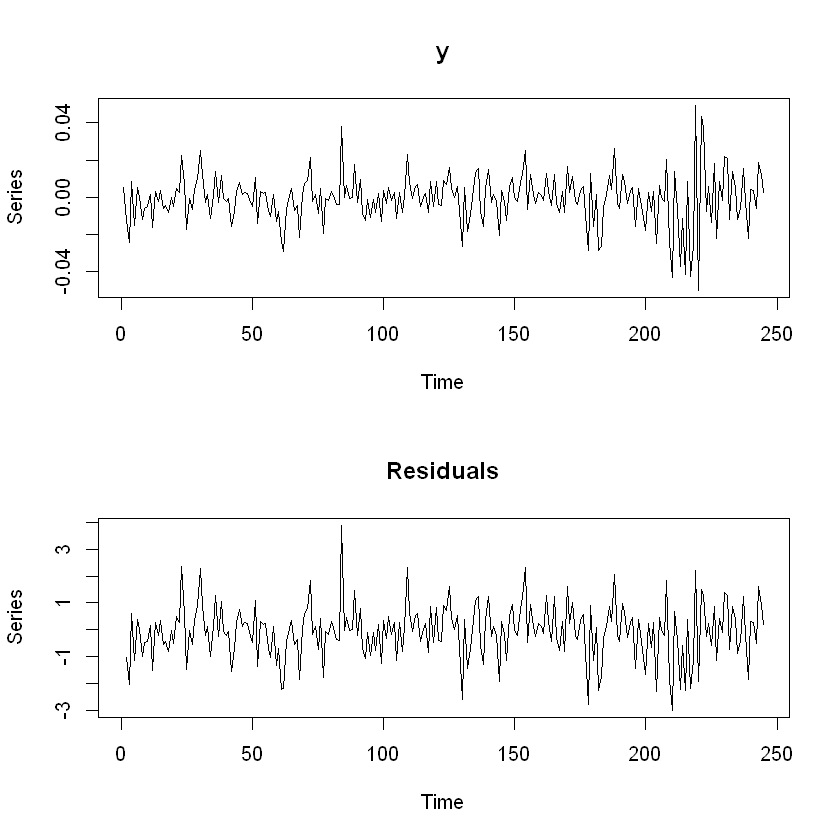

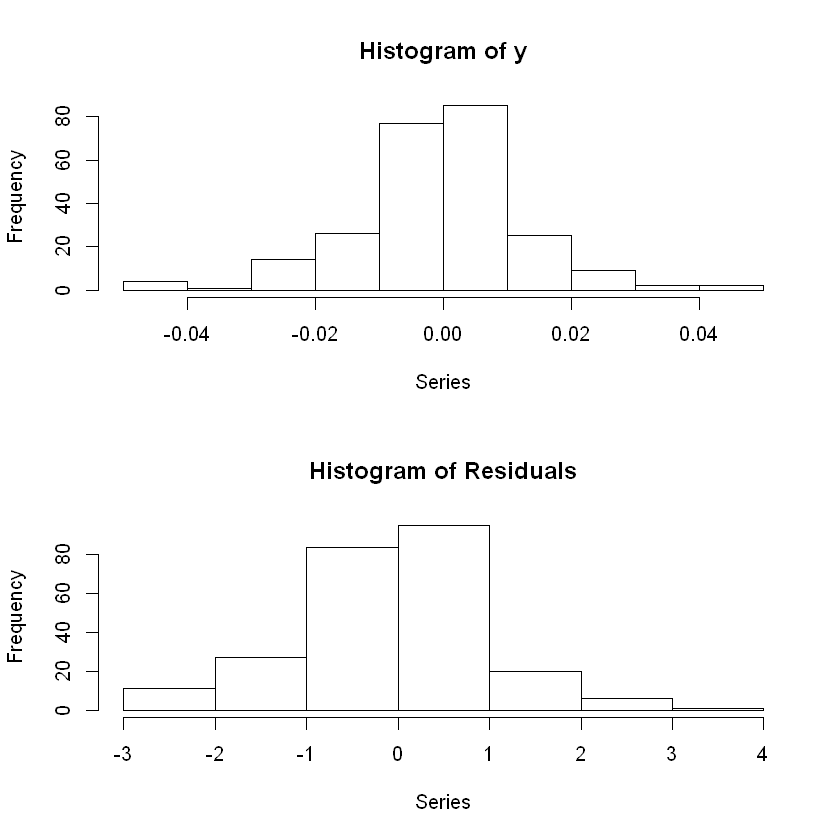

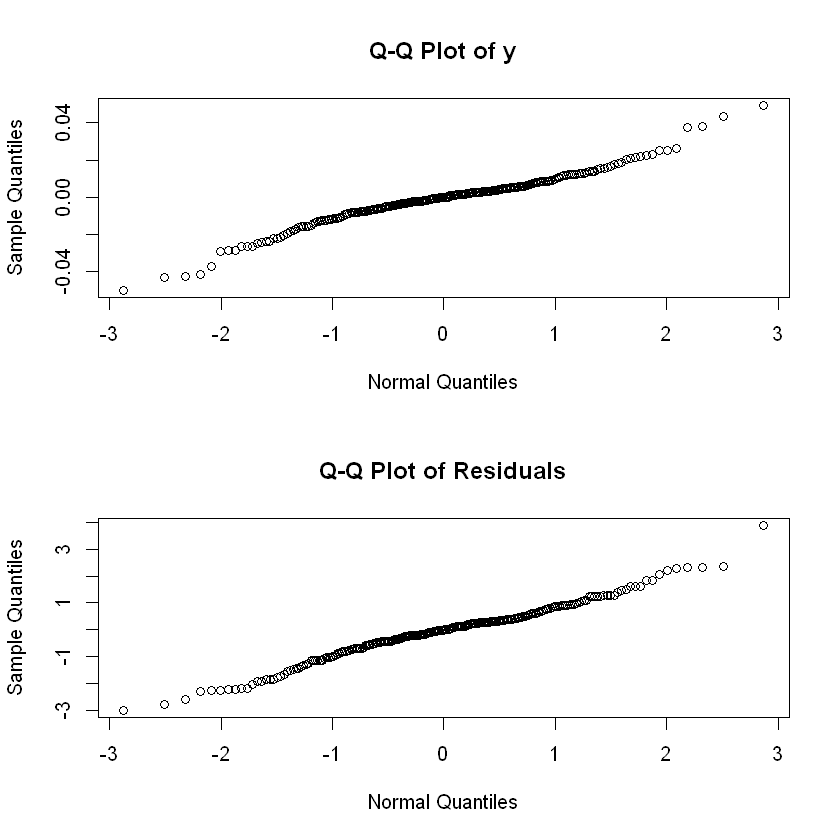

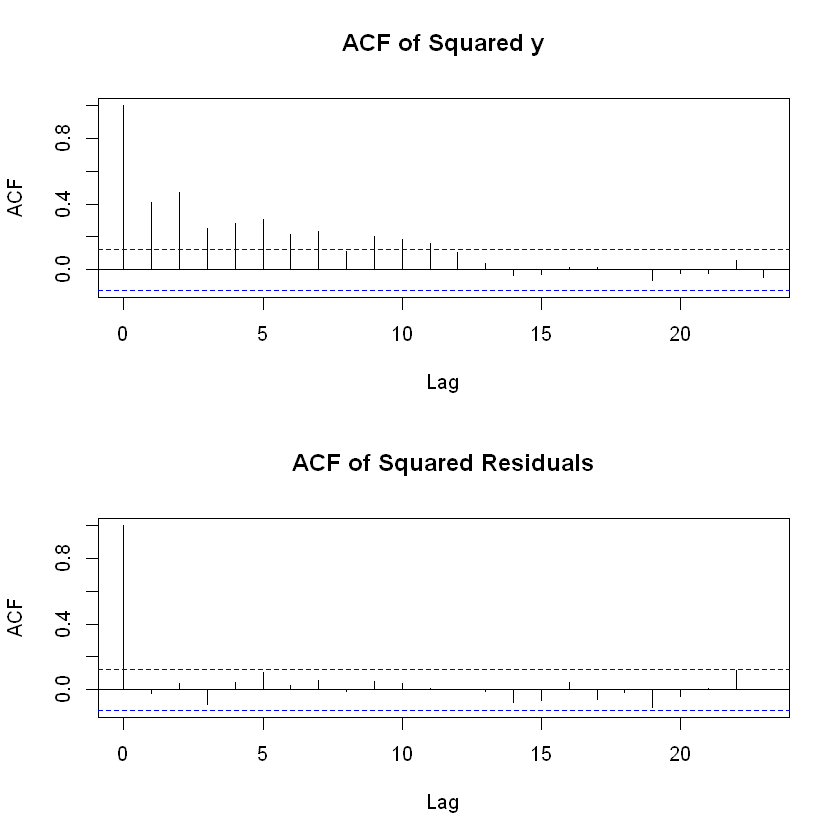

In [80]:
begin.dates = c("2019-05-03", "2019-05-04", "2019-05-05", "2019-05-06", "2019-05-07")
end.dates = c("2020-05-04", "2020-05-05", "2020-05-06", "2020-05-07", "2020-05-08")
df.ts = df[ date >= begin.dates[1] & date < end.dates[1], list(date, price.log.diff)]
tsdata = ts(df.ts$price.log.diff)
y <- tsdata
garch.y <- garch(y, order = c(1,1), trace=FALSE)  # Fit GARCH(1,1)
summary(garch.y)                     # Diagnostic tests

plot(garch.y)

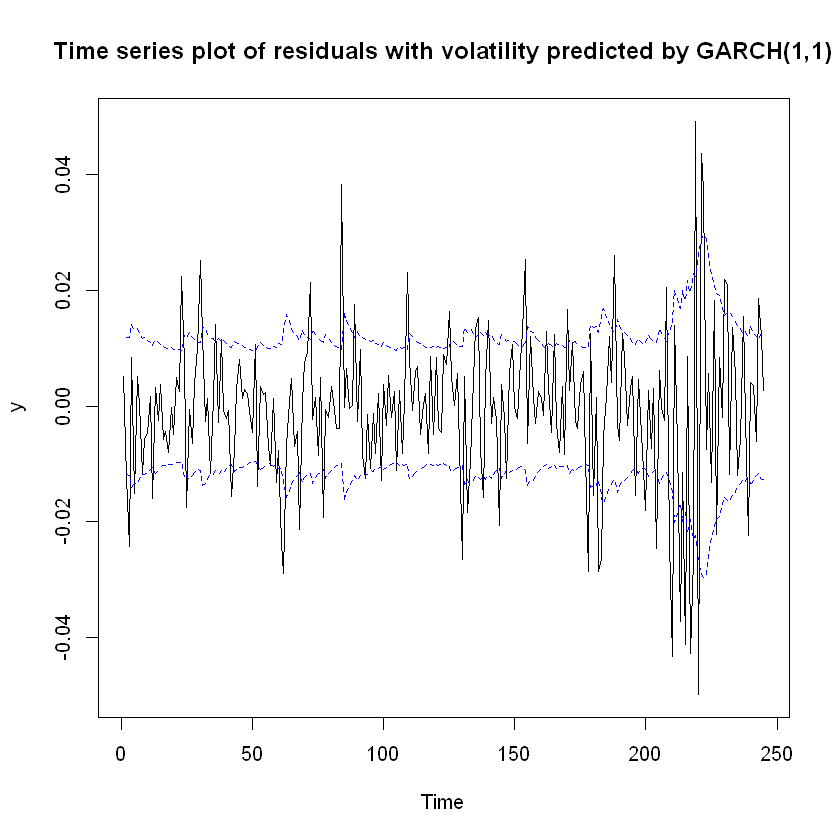

In [81]:
u = predict(garch.y)
u = u %>% na.omit
plot(y, type="l", xlab="Time", main = "Time series plot of residuals with volatility predicted by GARCH(1,1)")
lines(u[,1], col="blue", lty="dashed")
lines(u[,2], col="blue", lty="dashed")

The Ljung-Box test gives a p-value greater than 0.05, meaning the residuals of GARCH model do not have any autocorrelation and the model is a good fit. 

## HSI - Model Predictions

$R_t = \mu + \varepsilon_t$, $\varepsilon \sim N(0, \sigma_{\varepsilon}^2)$

#### Forecast for May 4:

In [42]:
f.1 = mean(df.ts$price.log.diff)
print(paste("The one-step ahead forecast is: ",f.1))

[1] "The one-step ahead forecast is:  -0.000693829163465112"


In [43]:
se = sqrt(var(df.ts$price.log.diff))
n = length(df.ts$price.log.diff)
t.value = f.1 / (se/sqrt(n-1))
print(paste("The t stat is: ", t.value))

[1] "The t stat is:  -0.808578224651696"


In [44]:
qt(0.05, n-1)

[1] -1.651123

Since t statistics is smaller than t value, we fail to reject the null hypothesis that the mean is zero.

In [45]:
y.truth = df[date == "2020-05-04", list(date, price.log.diff)]$price.log.diff
y.4 = y.truth
print(paste("The truth value is: ",y.truth))
eps.t.update = y.truth - f.1
e.4 = eps.t.update
print(paste("The forecast error is:", eps.t.update))

[1] "The truth value is:  -0.0426854998031203"
[1] "The forecast error is: -0.0419916706396552"


$\sigma_{t|t-1}^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1|t-2}^2$

$[f_{t,1} \pm 1.96*\sigma_{t+1|t}]$

In [48]:
fit = garchFit(formula~ garch(1,1), data=y,
                        trace=F) 
fit %>% summary


Title:
 GARCH Modelling 

Call:
 garchFit(formula = formula ~ garch(1, 1), data = y, trace = F) 

Mean and Variance Equation:
 data ~ garch(1, 1)
<environment: 0x000000002afa1488>
 [data = y]

Conditional Distribution:
 norm 

Coefficient(s):
         mu        omega       alpha1        beta1  
-1.6775e-04   2.0067e-05   1.1869e-01   7.5181e-01  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu     -1.677e-04   7.567e-04   -0.222  0.82456    
omega   2.007e-05   9.935e-06    2.020  0.04340 *  
alpha1  1.187e-01   4.277e-02    2.775  0.00552 ** 
beta1   7.518e-01   9.001e-02    8.352  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 732.2462    normalized:  2.98876 

Description:
 Sat May 30 14:20:13 2020 by user: Chan WingYiu 


Standardised Residuals Tests:
                                Statistic p-Value    
 Jarque-Bera Test   R    Chi^2  11.33754  0.003452101
 Shapiro-Wilk Test

In [49]:
fit = garchFit(formula~ garch(1,1), data=tsdata,
                        trace=F) 
omega = coef(fit)[2]
print(paste("omega=",omega))
alpha = coef(fit)[3]
print(paste("alpha",alpha))
beta = coef(fit)[4]
print(paste("beta",beta))
sigma.t = last(volatility(fit))
print(paste("sigma_{t|t-1}=",sigma.t))
epsilon.t = last(residuals(fit))
print(paste("epsilon_t=",epsilon.t))
sigma = omega + alpha * (epsilon.t)^2 + beta * (sigma.t)^2
s.4 = sigma^(1/2)
print(paste('1 step ahead forecast sigma=',sigma^(1/2)))

[1] "omega= 2.00674059307094e-05"
[1] "alpha 0.118690040116171"
[1] "beta 0.751811263120469"
[1] "sigma_{t|t-1}= 0.0126555862097496"
[1] "epsilon_t= 0.00291579834170463"
[1] "1 step ahead forecast sigma= 0.0118949354784586"


In [50]:
garch.y.fit = garchFit(formula~ garch(1,1), data=tsdata,
                        trace=F) 
vol.pred = predict(garch.y.fit, n.ahead = 1)
vol.pred

meanForecast,meanError,standardDeviation
<dbl>,<dbl>,<dbl>
-0.0001677461,0.01189494,0.01189494


In [51]:
lower.ci = f.1 - 1.96 * sigma^(1/2)
upper.ci = f.1 + 1.96 * sigma^(1/2)
print(paste('Prediction lower bound:',lower.ci))
print(paste('Prediction upper bound:',upper.ci))
print(paste("The truth value is: ",y.truth))

[1] "Prediction lower bound: -0.024007902701244"
[1] "Prediction upper bound: 0.0226202443743137"
[1] "The truth value is:  -0.0426854998031203"


#### Forecast for May 4 to 8:

In [52]:
begin.dates = c("2019-05-03", "2019-05-04", "2019-05-05", "2019-05-06", "2019-05-07")
end.dates = c("2020-05-04", "2020-05-05", "2020-05-06", "2020-05-07", "2020-05-08")
forecasts = rep(1:5)
prog.forecasts = rep(1:5)
sigma = rep(1:5)
prog.sigma = rep(1:5)
real.ret = df[ date >= "2020-05-04" & date <= "2020-05-08", list(date, price.log.diff)]

for( i in 1:5){
    df.ts = df[ date >= begin.dates[i] & date < end.dates[i], list(date, price.log.diff)]
    tsdata = ts(df.ts$price.log.diff, start = df$date[1], frequency = 365)
    fitARIMA <- arima(tsdata, order=c(0,0,0),method="ML", include.mean = FALSE)
    prog.forecasts[i] = predict(fitARIMA, n.ahead=1)$pred

    # Manual calculation of one-step ahead forecast:
#     ar1 = coef(fitARIMA)['ar1']
#     ar2 = coef(fitARIMA)['ar2']
#     # ar3 = coef(fitARIMA)['ar3']
#     ma1 = coef(fitARIMA)['ma1']
#     ma2 = coef(fitARIMA)['ma2']
#     mu = coef(fitARIMA)['intercept']
#     y.series = df.ts$price.log.diff
#     y.t = y.series[length(y.series)-0]
#     y.t.1 = y.series[length(y.series)-1]
    # y.t.2 = y.series[length(y.series)-2]
#     res = residuals(fitARIMA)
#     eps.t = res[length(res)-0]
#     eps.t.1 = res[length(res)-1]
    forecasts[i] = 0

    # Variance forecast
#     res = tsdata
    y <- tsdata

    fit = garchFit(formula~ garch(1,1), data=y,
                    trace=F) 
    omega = coef(fit)[2]
#     print(paste("omega:",omega))
    alpha = coef(fit)[3]
#     print(paste("alpha",alpha))
    beta = coef(fit)[4]
#     print(paste("beta",beta))
    sigma.t = last(volatility(fit))
#     print(paste("sigma_{t|t-1}:",sigma.t))
    epsilon.t = last(residuals(fit))
#     print(paste("epsilon_t:",epsilon.t))
    sigma[i] = sqrt(omega + alpha * (epsilon.t)^2 + beta * (sigma.t)^2)

    prog.sigma[i] = predict(fit, n.ahead = 1)$standardDeviation        
}

In [56]:
df.est = data.table(real.ret)
df.est[, forecast := forecasts]
df.est[, prog.forecast := prog.forecasts]
df.est[, sigma := sigma]
df.est[, variance:=sigma^2]
df.est[, prog.sigma:=prog.sigma]
df.est[, upper.ci := forecast + 1.96*sigma]
df.est[, lower.ci := forecast - 1.96*sigma]
df.est[, error := price.log.diff - forecast]
df.est[, sq.error := error^2%>%sqrt]
df.est[, abs.error := abs(error)]

df.est

date,price.log.diff,forecast,prog.forecast,sigma,variance,prog.sigma,upper.ci,lower.ci,error,sq.error,abs.error
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-05-04,-0.042685500,0,0,0.01189494,0.0001414895,0.01189494,0.02331407,-0.02331407,-0.042685500,0.042685500,0.042685500
2020-05-05,0.010734988,0,0,0.01846021,0.0003407795,0.01846021,0.03618202,-0.03618202,0.010734988,0.010734988,0.010734988
2020-05-06,0.011199531,0,0,0.01718400,0.0002952898,0.01718400,0.03368064,-0.03368064,0.011199531,0.011199531,0.011199531
2020-05-07,-0.006519382,0,0,0.01622410,0.0002632216,0.01622410,0.03179924,-0.03179924,-0.006519382,0.006519382,0.006519382
2020-05-08,0.010352091,0,0,0.01507546,0.0002272694,0.01507546,0.02954790,-0.02954790,0.010352091,0.010352091,0.010352091


In [57]:
rmse = mean(df.est$sq.error)
print(paste("RMSE: ", rmse))
mae = mean(df.est$abs.error)
print(paste("MAE: ", mae))

[1] "RMSE:  0.0162982981546545"
[1] "MAE:  0.0162982981546545"


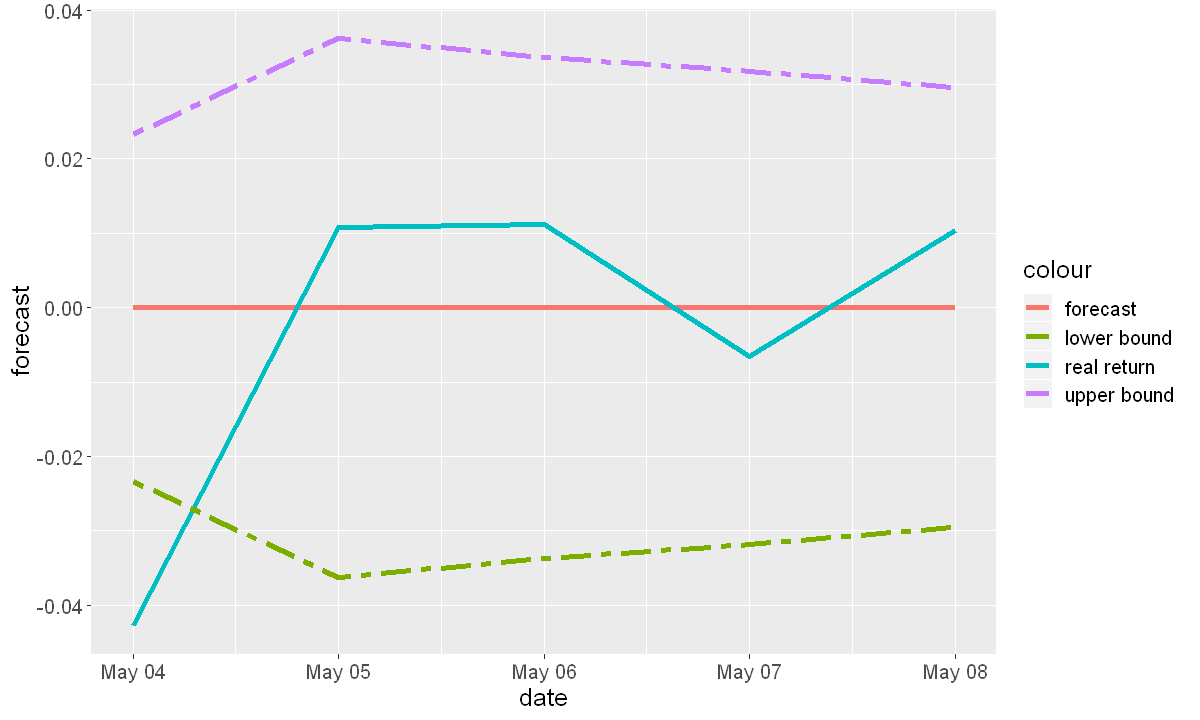

In [77]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
fig(10,6)
ggplot(data = df.est , aes(x=date))+
    geom_line(aes(y = forecast, color = "forecast"),lwd=1.5) +
    geom_line(aes(y = price.log.diff, color = "real return"),lwd=1.5) +
    geom_line(aes(y = lower.ci, color = "lower bound"), linetype = "twodash",lwd=1.5) +
    geom_line(aes(y = upper.ci, color = "upper bound"), linetype = "twodash",lwd=1.5) +
    theme(text = element_text(size=15)) +
    scale_size_manual( values = c(4,2,2) )